In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import os
from tqdm import tqdm
from icecream import ic
import plotly.express as px
from matplotlib.gridspec import GridSpec

In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from ipywidgets import widgets
from IPython.display import display, clear_output

In [3]:
# Step 2: Extract and Visualize Data from alldat.
# Load Data

# Filenames corresponding to the URLs
filenames = [
    'steinmetz_part1.npz',
    'steinmetz_part2.npz',
    'steinmetz_part3.npz'
]

lfp_filename = r"steinmetz_lfp.npz"

file_directory = r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\NEURONS"

save_dir = r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\figures"

# Function to load data from npz files
def load_data(filenames):
    alldat = np.array([])
    for filename in filenames:
        data = np.load(os.path.join(file_directory,filename), allow_pickle=True)['dat']
        alldat = np.hstack((alldat, data))
    return alldat

# Download data if not already present
# download_data(urls, filenames)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

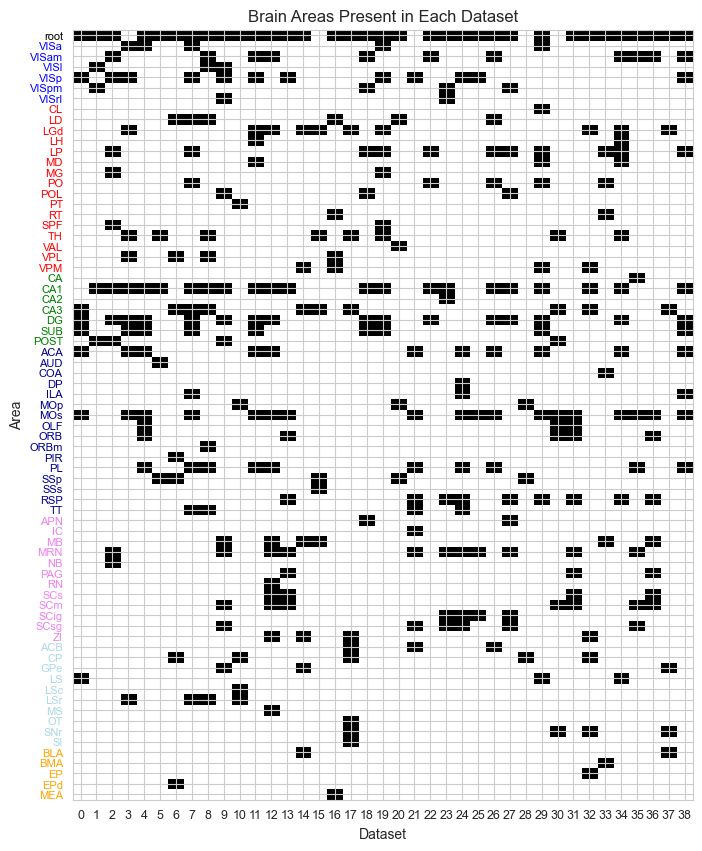

In [4]:
# Function to plot brain areas present in each dataset
def plot_brain_areas(data):
    # Brain Region Information
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                    ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                    ]

    # Assign Each Area an Index
    area_to_index = dict(root=0)
    counter = 1
    for group in brain_groups:
        for area in group:
            area_to_index[area] = counter
            counter += 1

    # Determine Areas in Each Dataset
    areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
    for j, d in enumerate(data):
        for area in np.unique(d['brain_area']):
            i = area_to_index.get(area, -1)
            if i != -1:
                areas_by_dataset[i, j] = True

    # Visualize the Presence of Neurons in Different Regions Across Datasets
    plt.figure(figsize=(8, 10))
    plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

    # Label the Axes
    plt.xlabel("Dataset")
    plt.ylabel("Area")

    # Add Tick Labels
    yticklabels = ["root"]
    for group in brain_groups:
        yticklabels.extend(group)
    plt.yticks(np.arange(counter), yticklabels, fontsize=8)
    plt.xticks(np.arange(len(data)), fontsize=9)
 
    ytickobjs = plt.gca().get_yticklabels()
    ytickobjs[0].set_color("black")
    counter = 1
    for group, color in zip(brain_groups, region_colors):
        for area in group:
            ytickobjs[counter].set_color(color)
            counter += 1

    plt.title("Brain Areas Present in Each Dataset")
    plt.grid(True)
    plt.show()

# Plot brain areas present in each dataset
alldat = load_data(filenames)
plot_brain_areas(alldat)

In [5]:
alldat = load_data(filenames)

In [6]:
print(alldat[1].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [7]:
ic(alldat[1]['spks'].shape)
ic(alldat[1]['wheel'].shape)
ic(alldat[1]['response_time'].shape)
ic(alldat[1]['stim_onset'])
ic(alldat[1]['feedback_time'].shape)
ic(alldat[1]['feedback_type'].shape)
ic(alldat[1]['pupil'].shape)
ic(alldat[1]['prev_reward'].shape)
ic(alldat[1]['reaction_time'].shape)
ic(alldat[1]['face'].shape)
ic(alldat[1]['licks'].shape)
ic(alldat[1]['wheel'].shape)

ic| alldat[1]['spks'].shape: (1070, 251, 250)
ic| alldat[1]['wheel'].shape: (1, 251, 250)
ic| alldat[1]['response_time'].shape: (251, 1)
ic| alldat[1]['stim_onset']: 0.5
ic| alldat[1]['feedback_time'].shape: (251, 1)
ic| alldat[1]['feedback_type'].shape: (251,)
ic| alldat[1]['pupil'].shape: (3, 251, 250)
ic| alldat[1]['prev_reward'].shape: (251, 1)
ic| alldat[1]['reaction_time'].shape: (251, 2)
ic| alldat[1]['face'].shape: (1, 251, 250)
ic| alldat[1]['licks'].shape: (1, 251, 250)
ic| alldat[1]['wheel'].shape: (1, 251, 250)


(1, 251, 250)

In [112]:
ic(alldat[1]['response'] == alldat[1]['reaction_time'][:,1])

ic| alldat[1]['response'] == alldat[1]['reaction_time'][:,1]: array([ True,  True, False,  True,  True,  True,  True,  True,  True,
                                                                     False,  True,  True,  True,  True, False,  True, False,  True,
                                                                     False, False,  True,  True,  True,  True,  True,  True,  True,
                                                                     False,  True,  True,  True,  True,  True,  True, False,  True,
                                                                     False, False,  True,  True, False,  True, False,  True,  True,
                                                                      True, False,  True,  True, False,  True, False, False,  True,
                                                                      True,  True,  True, False,  True,  True,  True,  True, False,
                                                                      True, 

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True, False,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True, False,  True, False,  True,  True,
        True, False,  True,  True, False,  True, False, False,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,

In [9]:
ic(alldat[1]['reaction_time'][:,0])

ic| alldat[1]['reaction_time'][:,0]: array([ 230., 1460.,  250.,  180.,  450.,   inf,  110.,  160.,  390.,
                                             560.,  170.,   90.,  200.,  180.,  170.,  160.,  230.,  340.,
                                             200.,  440.,   inf,  100.,  200.,  160.,  830.,  150.,  130.,
                                             320.,  160.,  190.,  170.,   80.,  170.,   inf, 1240.,  210.,
                                             190.,  360.,  340.,   inf,  260.,  190.,  280.,  100.,  160.,
                                             210.,   40.,   inf,   inf,  150.,  180.,  920.,  310.,  160.,
                                             170.,  180.,  160.,  110.,  390.,   inf,  180.,   inf,  260.,
                                             570.,   50.,  160.,   70.,  210.,  220.,   inf,  190.,   inf,
                                             180.,  540.,  160., 1020.,  180., 1050.,  510.,  160.,  220.,
                                     

array([ 230., 1460.,  250.,  180.,  450.,   inf,  110.,  160.,  390.,
        560.,  170.,   90.,  200.,  180.,  170.,  160.,  230.,  340.,
        200.,  440.,   inf,  100.,  200.,  160.,  830.,  150.,  130.,
        320.,  160.,  190.,  170.,   80.,  170.,   inf, 1240.,  210.,
        190.,  360.,  340.,   inf,  260.,  190.,  280.,  100.,  160.,
        210.,   40.,   inf,   inf,  150.,  180.,  920.,  310.,  160.,
        170.,  180.,  160.,  110.,  390.,   inf,  180.,   inf,  260.,
        570.,   50.,  160.,   70.,  210.,  220.,   inf,  190.,   inf,
        180.,  540.,  160., 1020.,  180., 1050.,  510.,  160.,  220.,
        230.,  180.,  140.,  170.,  190.,  210.,  230.,   inf, 1630.,
        870., 1280., 1060.,  210.,  190.,  340., 1260., 1200.,   inf,
        220.,  180.,   inf,   inf,  500.,  210.,  570.,  140.,  860.,
         inf,  180.,  240.,  180.,  930.,  220.,  170.,  260.,  240.,
        310.,   inf,  210.,  410.,  690.,  200.,  580., 1230.,   inf,
         inf,  950.,

In [10]:
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

In [11]:
brain_areas = []
for region in brain_groups:
    brain_areas += region
print(brain_areas)

['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl', 'CL', 'LD', 'LGd', 'LH', 'LP', 'MD', 'MG', 'PO', 'POL', 'PT', 'RT', 'SPF', 'TH', 'VAL', 'VPL', 'VPM', 'CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST', 'ACA', 'AUD', 'COA', 'DP', 'ILA', 'MOp', 'MOs', 'OLF', 'ORB', 'ORBm', 'PIR', 'PL', 'SSp', 'SSs', 'RSP', 'TT', 'APN', 'IC', 'MB', 'MRN', 'NB', 'PAG', 'RN', 'SCs', 'SCm', 'SCig', 'SCsg', 'ZI', 'ACB', 'CP', 'GPe', 'LS', 'LSc', 'LSr', 'MS', 'OT', 'SNr', 'SI', 'BLA', 'BMA', 'EP', 'EPd', 'MEA']


In [12]:
def plot_neuron_spikes(spike_data, ax):

                    
    num_neurons = len(spike_data)

    neurons_round = rounded = int(np.ceil(num_neurons / 1000) * 1000)
    
    # Plot spikes using eventplot
    ax.eventplot(spike_data, lineoffsets=range(num_neurons),
                 linelengths=1, colors='black',linestyles='solid')
    
    # Set y-axis ticks and labels
    ax.set_yticks([0, neurons_round//2, neurons_round])
    # ax.set_yticklabels(['1', f'{num_neurons//2}', f'{num_neurons}'])
    ax.set_xticks(np.arange(-500, 2000, 500))
    # ax.set_yticklabels(['-500','0','500','1000','1500','2000'])
    # Set labels and title
    ax.set_ylabel('Neuron')

In [13]:
def trial_subroutines(key, value):
    match key:
        case 'response':
            return value
        case 'response_time':
            return np.squeeze(value)
        case 'contrast_left':
            return value
        case 'contrast_right':
            return value
        case 'feedback_time':
            return np.squeeze(value)
        case 'feedback_type':
            return value
        case 'gocue':
            return np.squeeze(value)
        case 'prev_reward':
            return np.squeeze(value)
        case _:
            return None

In [14]:
def neuron_subroutines(key, value):
    match key:
        case 'brain_area':
            return value
        # case 'ccf':
        #     return value
        case _:
            return None


In [103]:
def dat_subroutines(dat):
    neuron_data = {}
    trial_data = {}
    for key, value in dat.items():
        neuron_result = neuron_subroutines(key, value)
        trial_result = trial_subroutines(key, value)





        # Only add to dictionary if the result is not
        if neuron_result is not None:
            neuron_data[key] = neuron_result
        if trial_result is not None:
            trial_data[key] = trial_result


    # Create DataFrames from the processed data
    neuron_df = pd.DataFrame(neuron_data)
    trial_df = pd.DataFrame(trial_data)


    # Add common fields
    for df in [neuron_df, trial_df]:
        if 'mouse_name' in dat:
            df['mouse_name'] = dat['mouse_name']
        if 'date_exp' in dat:
            df['date_exp'] = pd.to_datetime(dat['date_exp'])

    neuron_df[[*dat['ccf_axes']]] = dat['ccf']
    trial_df[['reaction_time','reaction_type']] = dat['reaction_time']

    trial_df['pupil_area'] = list(dat['pupil'][0,:,:])
    trial_df['pupil_x'] = list(dat['pupil'][1,:,:])
    trial_df['pupil_y'] = list(dat['pupil'][2,:,:])
    trial_df['face'] = list(np.squeeze(dat['face']))
    trial_df['licks'] = list(np.squeeze(dat['licks']))
    trial_df['wheel'] = list(np.squeeze(dat['wheel']))
    trial_df['average_pupil_speed'] = list(np.sqrt(((np.diff(dat['pupil'][1,:,:], axis=1)/0.01)**2)+((np.diff(dat['pupil'][2,:,:], axis=1)/0.01)**2)))

    # Add index columns
    neuron_df['neuron_id'] = range(len(neuron_df))
    trial_df['trial_id'] = range(len(trial_df))

    # Create cross join between neurons and trials
    # First, add a temporary key for merging
    neuron_df['_merge_key'] = 1
    trial_df['_merge_key'] = 1

    # Perform the merge
    merged_df = pd.merge(
        neuron_df,
        trial_df,
        on='_merge_key',
        suffixes=('_neuron', '_trial')
    ).drop('_merge_key', axis=1)

    # Deduplicate common columns (mouse_name and date_exp)
    for col in merged_df.columns:
        if col.endswith('_neuron') and col.replace('_neuron', '_trial') in merged_df.columns:
            base_col = col.replace('_neuron', '')
            if (merged_df[col] == merged_df[col.replace('_neuron', '_trial')]).all():
                merged_df[base_col] = merged_df[col]
                merged_df = merged_df.drop([col, col.replace('_neuron', '_trial')], axis=1)

    # Reset the index
    merged_df = merged_df.reset_index(drop=True)
    spikes = dat['spks'].reshape(-1,250)



    merged_df['spks'] = list(spikes)

    return merged_df


In [104]:
concat_df = pd.DataFrame()
dfs=[]
for dat in alldat:
    dfs.append(dat_subroutines(dat))
    
concat_df = pd.concat(dfs)
ic(concat_df.shape)

dfs_select = []
for area in concat_df.brain_area.unique():
    selected_df = concat_df.query(f'brain_area == "{area}"')
    ic(selected_df.shape)
    # Create a mapping dictionary from old to new IDs
    unique_neurons = selected_df.neuron_id.unique()
    new_neuron_ids = np.arange(len(unique_neurons))
    id_mapping = dict(zip(unique_neurons, new_neuron_ids))
    
    # Map old IDs to new IDs
    selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
    dfs_select.append(selected_df)
        
concat_df = pd.concat(dfs_select)
ic(concat_df.shape)


ic| concat_df.shape: (8787226, 26)
ic| selected_df.shape: (227065, 26)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_12608\4168728797.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

ic| selected_df.shape: (423791, 26)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_12608\4168728797.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

ic| selected_df.shape: (104576, 26)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_12608\4168728797.py:19: SettingWithCopyWarning:


A value is trying to be set o

(8787226, 26)

In [106]:
concat_df.head()

brain_area      ap      dv      lr  neuron_id  response  response_time  \
0        ACA  4090.0  2445.4  5012.4          0       1.0       1.150204   
1        ACA  4090.0  2445.4  5012.4          0      -1.0       1.399503   
2        ACA  4090.0  2445.4  5012.4          0       1.0       0.949291   
3        ACA  4090.0  2445.4  5012.4          0       0.0       2.266802   
4        ACA  4090.0  2445.4  5012.4          0       1.0       0.816776   

   contrast_right  contrast_left  feedback_time  ...  \
0             0.0            1.0       1.186819  ...   
1             0.5            0.0       1.437623  ...   
2             0.5            1.0       0.986016  ...   
3             0.0            0.0       2.296436  ...   
4             1.0            0.5       0.827613  ...   

                                             pupil_x  \
0  [0.8128560079370007, 0.7781619288408106, 0.812...   
1  [0.9481738640399882, 0.95962931787718, 0.95623...   
2  [0.3880897000778937, 0.38561680094358525, 0.32...   
3  [0.5486736122593511, 0.5706127730128381, 0.607...   
4  [0.16297604976200375, 0.11803934958464492, 0.1...   

                                             pupil_y  \
0  [0.6642474546970106, 0.6127515969655603, 0.632...   
1  [1.2327374650971357, 1.1461163994720454, 1.075...   
2  [-0.5459380913456507, -0.5497186468959199, -0....   
3  [0.31674671014607647, 0.3865733154225462, 0.58...   
4  [-0.001497431166922816, 0.11724225390846806, 0...   

                                                face  \
0  [1.1457347728534013, 1.1457347728534013, 1.145...   
1  [2.017052985665972, 2.017052985665972, 2.01705...   
2  [1.4639606285105065, 1.4639606285105065, 1.126...   
3  [1.7438533505033715, 1.7438533505033715, 1.757...   
4  [1.3459189153222113, 0.717377215716495, 0.7173...   

                                               licks  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               wheel  \
0  [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [0.0, -1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 1.0...   
2  [0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0,...   

                                 average_pupil_speed trial_id mouse_name  \
0  [6.209269270880815, 3.9618719802556384, 15.514...        0       Cori   
1  [8.737526213203733, 7.03354040999631, 13.82820...        1       Cori   
2  [0.4517502672620578, 5.709125370596854, 3.9920...        2       Cori   
3  [7.319208686055655, 20.082483878493004, 2.8472...        3       Cori   
4  [12.695833897240796, 3.510899717497929, 16.199...        4       Cori   

    date_exp                                               spks  
0 2016-12-14  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1 2016-12-14  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2 2016-12-14  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3 2016-12-14  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4 2016-12-14  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[5 rows x 26 columns]

In [111]:
ic(concat_df['feedback_type'].unique())
ic(concat_df['reaction_type'].unique())

ic| concat_df['feedback_type'].unique(): array([ 1., -1.])
ic| concat_df['reaction_type'].unique(): array([ 1., -1.,  0.])


array([ 1., -1.,  0.])

In [68]:
right_response = -1
left_response = 1
correct_feedback = 1
incorrect_feedback = -1

left_correct_reward = concat_df.query('(contrast_left > contrast_right) & (response == @left_response) & (feedback_type == @correct_feedback)')
left_correct_penalty = concat_df.query('(contrast_left > contrast_right) & (response == @right_response) & (feedback_type == @incorrect_feedback)')

right_correct_reward = concat_df.query('(contrast_left < contrast_right) & (response == @right_response) & (feedback_type == @correct_feedback)')
right_correct_penalty = concat_df.query('(contrast_left < contrast_right) & (response == @left_response) & (feedback_type == @incorrect_feedback)')

left_incorrect_reward = concat_df.query('(contrast_left < contrast_right) & (response == @left_response) & (feedback_type == @correct_feedback)')
right_incorrect_reward = concat_df.query('(contrast_left > contrast_right) & (response == @right_response) & (feedback_type == @correct_feedback)')  # Removed extra }

nogo_trials = concat_df.query('response == 0')

In [72]:
left_correct_reward.query('brain_area == "VISp"').response_time.unique()

array([1.02721625, 0.82521303, 1.07121695, 0.64601017, 0.96601527,
       1.07081695, 1.01921612, 0.84121328, 0.82441302, 0.7856124 ,
       1.11761769, 0.50400791, 0.68161074, 1.04321651, 1.06321682,
       0.56800893, 0.78761243, 0.62680987, 0.54880862, 0.94561495,
       0.58680923, 1.02761626, 0.83681321, 0.58800925, 0.85761355,
       0.99081567, 0.95201505, 1.00561591, 0.81641289, 0.60200947,
       0.7856124 , 0.8044127 , 0.52960832, 1.03201633, 0.7544119 ,
       0.63120994, 0.50560793, 0.60200947, 0.53160835, 0.67721067,
       0.70361109, 0.79921261, 0.74281172, 0.55280869, 0.90961438,
       0.91521446, 0.60960959, 1.17001853, 1.14121807, 1.07161696,
       0.89361412, 0.69121088, 0.61240962, 1.02601621, 0.75161184,
       0.94841497, 0.824413  , 1.11441762, 0.60680954, 0.64161009,
       1.1448181 , 1.04161646, 0.78321234, 0.54040848, 0.89641415,
       0.73801162, 0.49880782, 0.99961579, 0.94201487, 0.50280788,
       1.10961754, 1.1636184 , 0.67801067, 0.6232098 , 1.04841

In [20]:
ic(left_correct_reward.shape)
ic(left_correct_penalty.shape)
ic(right_correct_reward.shape)
ic(right_correct_penalty.shape)
ic(nogo_trials.shape)
ic(left_incorrect_reward.shape)
ic(right_incorrect_reward.shape)

ic| left_correct_reward.shape: (2145462, 26)
ic| left_correct_penalty.shape: (173521, 26)
ic| right_correct_reward.shape: (2062252, 26)
ic| right_correct_penalty.shape: (212923, 26)
ic| nogo_trials.shape: (2964781, 26)
ic| left_incorrect_reward.shape: (0, 26)
ic| right_incorrect_reward.shape: (0, 26)


(0, 26)

In [21]:
# load_df = pd.read_csv(os.path.join(save_dir,'steinmetz_neuron_spikes.csv'))

In [22]:
def str_to_array(string:str) -> np.ndarray:
    array = np.array(string.strip('[]').split()).astype(np.float64)
    return array
    

In [23]:
raster_image = np.array(left_correct_penalty.query('brain_area == "CA1" & neuron_id == 30').spks.to_list())

In [24]:
concat_df.query('brain_area == "CA1"').groupby(['mouse_name','date_exp']).spks.mean().index

MultiIndex([(     'Cori', '2016-12-17'),
            (     'Cori', '2016-12-18'),
            ('Forssmann', '2017-11-01'),
            ('Forssmann', '2017-11-02'),
            ('Forssmann', '2017-11-04'),
            (    'Hench', '2017-06-15'),
            (    'Hench', '2017-06-16'),
            (    'Hench', '2017-06-17'),
            ('Lederberg', '2017-12-05'),
            ('Lederberg', '2017-12-06'),
            ('Lederberg', '2017-12-07'),
            (    'Moniz', '2017-05-15'),
            (    'Moniz', '2017-05-16'),
            (   'Muller', '2017-01-08'),
            (   'Muller', '2017-01-09'),
            (  'Radnitz', '2017-01-10'),
            (  'Radnitz', '2017-01-11'),
            ( 'Richards', '2017-10-29'),
            ( 'Richards', '2017-11-01'),
            (    'Tatum', '2017-12-06'),
            (  'Theiler', '2017-10-11')],
           names=['mouse_name', 'date_exp'])

In [25]:
# def plot_decision_trials(data_df:pd.DataFrame, area:str, neuron_no):
#     """
#     Create a 2x2 grid of raster plots with their PSTHs
#     
#     Parameters:
#     spike_data_list: list of numpy arrays, each of shape (n, 250) containing spike counts
#     titles_list: list of strings for subplot titles
#     
#     Returns:
#     plotly.graph_objects.Figure
#     """
#     titles_list = ['Left Contrast Reward', 'Left Contrast Penalty','', '', 'Right Contrast Reward', 'Right Contrast Penalty']
#     
#     right_response = -1
#     left_response = 1
#     correct_feedback = 1
#     incorrect_feedback = -1
#     
#     left_correct_reward = data_df.query(f'(contrast_left > contrast_right) & (response == @left_response) & (feedback_type == @correct_feedback) ')
#     left_correct_penalty = data_df.query('(contrast_left > contrast_right) & (response == @right_response) & (feedback_type == @incorrect_feedback)')
# 
#     right_correct_reward = data_df.query('(contrast_left < contrast_right) & (response == @right_response) & (feedback_type == @correct_feedback)')
#     right_correct_penalty = data_df.query('(contrast_left < contrast_right) & (response == @left_response) & (feedback_type == @incorrect_feedback)')
#     
#     
#     df_list = [left_correct_reward, left_correct_penalty, right_correct_reward, right_correct_penalty]
#     df_filtered = [x.query(f'brain_area == "{area}" & neuron_id == {neuron_no}') for x in df_list]
#     
#     # Check if any of the filtered DataFrames are empty
#     if any(len(df) == 0 for df in df_filtered):
#         # Create an empty figure with a message
#         fig = go.Figure()
#         fig.add_annotation(
#             text=f"No data available for {area} Neuron {neuron_no}",
#             xref="paper",
#             yref="paper",
#             x=0.5,
#             y=0.5,
#             showarrow=False,
#             font=dict(size=20)
#         )
#         fig.update_layout(
#             width=1500,
#             height=1200,
#             title=f'{area} of Neuron {neuron_no} - No Data Available'
#         )
#         return fig
#     
#     
#     spikes_list = [np.array(y.spks.to_list()) for y in df_filtered]
#     
#     
#     
#     # Create figure with 2x2 grid, where each cell contains a raster+PSTH subplot
#     fig = make_subplots(
#         rows=4, cols=2,
#         row_heights=[0.7, 0.3, 0.7, 0.3],  # Alternate between raster (0.7) and PSTH (0.3)
#         vertical_spacing=0.1,
#         horizontal_spacing=0.1,
#         subplot_titles=titles_list
#     )
#     
#     # Time points for x-axis
#     time_points = np.arange(-495, 2005, 10)
#     
#     maximum = np.max([np.max(s) for s in spikes_list])
#     # Map to convert from plot number to subplot positions
#     position_map = {
#         0: {'raster': (1, 1), 'psth': (2, 1)},
#         1: {'raster': (1, 2), 'psth': (2, 2)},
#         2: {'raster': (3, 1), 'psth': (4, 1)},
#         3: {'raster': (3, 2), 'psth': (4, 2)}
#     }
#     
#     # Create each subplot
#     for idx, spike_data in enumerate(spikes_list):
#         # Calculate PSTH
#         psth = np.mean(spike_data, axis=0)
#         
#         # Get position for this plot
#         pos = position_map[idx]
#         
#         # Add raster plot
#         fig.add_trace(
#             go.Heatmap(
#                 z=spike_data,
#                 x=time_points,
#                 colorscale='Greys',
#                 showscale=True if idx == 1 else False,  # Only show colorbar for first plot
#                 zmin=0,
#                 zmax= maximum,
#                 colorbar=dict(
#                     title='Spike Count',
#                     titleside='right',
#                     thickness=20,
#                     len=0.1,
#                     yanchor='middle',
#                 ) if idx == 0 else None,
#             ),
#             row=pos['raster'][0], col=pos['raster'][1]
#         )
#         
#         # Add PSTH
#         fig.add_trace(
#             go.Scatter(
#                 x=time_points,
#                 y=psth,
#                 mode='lines',
#                 line=dict(color='blue', width=2),
#                 showlegend=False
#             ),
#             row=pos['psth'][0], col=pos['psth'][1]
#         )
#         
#         # Add stimulus onset line for raster
#         fig.add_trace(
#             go.Scatter(
#                 x=[0, 0],
#                 y=[0, spike_data.shape[0]],
#                 mode='lines',
#                 line=dict(color='red', dash='dash', width=2),
#                 name='Stimulus Onset',
#                 showlegend=(idx == 0)  # Only show in legend for first plot
#             ),
#             row=pos['raster'][0], col=pos['raster'][1]
#         )
#         
#         # Add stimulus onset line for PSTH
#         fig.add_trace(
#             go.Scatter(
#                 x=[0, 0],
#                 y=[0, np.max(psth) * 1.1],
#                 mode='lines',
#                 line=dict(color='red', dash='dash', width=2),
#                 showlegend=False
#             ),
#             row=pos['psth'][0], col=pos['psth'][1]
#         )
#         
#         # Update axes for this pair of plots
#         for subplot_type in ['raster', 'psth']:
#             row, col = pos[subplot_type]
#             
#             # X-axis updates
#             fig.update_xaxes(
#                 tickmode='linear',
#                 tick0=-500,
#                 dtick=100,
#                 range=[-500, 2000],
#                 row=row, col=col
#             )
#             
#             # Add x-axis title only for PSTH plots
#             if subplot_type == 'psth':
#                 fig.update_xaxes(title='Time (ms)', row=row, col=col)
#             
#             # Y-axis updates
#             if subplot_type == 'raster':
#                 fig.update_yaxes(
#                     tickmode='linear',
#                     tick0=-0,
#                     dtick=50 if spike_data.shape[0] > 100 else 5,
#                     range=[-0.5, spike_data.shape[0]-1],
#                     title='Trials',
#                     row=row, col=col
#                 )
#             else:
#                 fig.update_yaxes(
#                     title='Average Spikes/Trial',
#                     row=row, col=col
#                 )
#     
#     # Update overall layout
#     fig.update_layout(
#         width=1500,
#         height=1200,
#         showlegend=True,
#         legend=dict(
#             yanchor="top",
#             y=0.99,
#             xanchor="left",
#             x=0.01,
#             bgcolor='rgba(255, 255, 255, 0.8)'
#         ),
#         title=f'{area} of Neuron {neuron_no} Spike Train Raster Plots with PSTH'
#     )
#     
#     return fig
# 
# # Example usage:
# """
# # Generate sample data
# n_trials = 30
# n_plots = 4
# spike_data_list = [np.random.poisson(lam=0.5, size=(n_trials, 250)) for _ in range(n_plots)]
# titles_list = [f'Neuron {i+1}' for i in range(n_plots)]
# 
# # Create and show the plot
# fig = create_multi_raster_plot(spike_data_list, titles_list)
# fig.show()
# """

In [26]:
def plot_decision_trials(data_df: pd.DataFrame, area: str, neuron_no):
    """
    Create a 2x2 grid of raster plots with their PSTHs, sorted by contrast difference
    with a secondary y-axis showing contrast difference values at higher resolution

    Parameters:
    data_df: DataFrame containing trial data
    area: str, the brain area to filter by
    neuron_no: neuron identifier

    Returns:
    plotly.graph_objects.Figure
    """
    # Define parameters and filter conditions
    titles_list = ['Left Contrast Reward', 'Left Contrast Penalty', '', '', 'Right Contrast Reward', 'Right Contrast Penalty']
    right_response = -1
    left_response = 1
    correct_feedback = 1
    incorrect_feedback = -1

    left_correct_reward = data_df.query(f'(contrast_left > contrast_right) & (response == @left_response) & (feedback_type == @correct_feedback)')
    left_correct_penalty = data_df.query('(contrast_left > contrast_right) & (response == @right_response) & (feedback_type == @incorrect_feedback)')
    right_correct_reward = data_df.query('(contrast_left < contrast_right) & (response == @right_response) & (feedback_type == @correct_feedback)')
    right_correct_penalty = data_df.query('(contrast_left < contrast_right) & (response == @left_response) & (feedback_type == @incorrect_feedback)')

    df_list = [left_correct_reward, left_correct_penalty, right_correct_reward, right_correct_penalty]
    df_filtered = [x.query(f'brain_area == "{area}" & neuron_id == {neuron_no}') for x in df_list]

    # Sort each DataFrame by contrast difference and store contrast differences
    sorted_df_filtered = []
    contrasts_list = []
    for i, df in enumerate(df_filtered):
        if i < 2:
            df['contrast'] = df['contrast_left']
        else:
            df['contrast'] = df['contrast_right']
        sorted_df = df.sort_values('contrast', ascending=True)
        sorted_df_filtered.append(sorted_df)
        contrasts_list.append(sorted_df['contrast'].values)

    spikes_list = [np.array(df.spks.to_list()) for df in sorted_df_filtered]
    

    # Create figure with 2x2 grid
    fig = make_subplots(
        rows=4, cols=2,
        row_heights=[0.7, 0.3, 0.7, 0.3],
        vertical_spacing=0.1,
        horizontal_spacing=0.1,
        subplot_titles=titles_list,
        specs=[[{"secondary_y": True}, {"secondary_y": True}],
               [{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": True}, {"secondary_y": True}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    # Time points for x-axis
    time_points = np.arange(-495, 2005, 10)
    maximum = np.max([np.max(s) for s in spikes_list])

    position_map = {
        0: {'raster': (1, 1), 'psth': (2, 1)},
        1: {'raster': (1, 2), 'psth': (2, 2)},
        2: {'raster': (3, 1), 'psth': (4, 1)},
        3: {'raster': (3, 2), 'psth': (4, 2)}
    }

    # Create each subplot with placeholders if data is insufficient
    for idx, (spike_data, contrasts) in enumerate(zip(spikes_list, contrasts_list)):
        pos = position_map[idx]
        
        # If there are fewer than 10 trials, add a placeholder
        if spike_data.shape[0] < 10:
            fig.add_annotation(
                text=f"Not enough trial data  for {titles_list[idx]}",
                xref="x", yref="y",
                x=0.5, y=0.5,
                xanchor='center', yanchor='middle',
                font=dict(size=16),
                row=pos['raster'][0], col=pos['raster'][1],
                showarrow=False
            )
            
            fig.add_annotation(
                text=f"Not enough trial data  for {titles_list[idx]}",
                xref="x", yref="y",
                x=0.5, y=0.5,
                xanchor='center', yanchor='middle',
                font=dict(size=16),
                row=pos['psth'][0], col=pos['psth'][1],
                showarrow=False
            )
            continue

        # If sufficient data, proceed with plotting
        psth = np.mean(spike_data, axis=0) / (10 / 1000)
        
        # Add raster plot
        fig.add_trace(
            go.Heatmap(
                z=spike_data,
                x=time_points,
                colorscale='Greys',
                showscale=True if idx == 2 else False,
                zmin=0,
                zmax=maximum,
                colorbar=dict(
                    title='Spike Count',
                    titleside='right',
                    thickness=20,
                    len=0.1,
                    yanchor='middle',
                ) if idx == 0 else None,
            ),
            row=pos['raster'][0], col=pos['raster'][1],
            secondary_y=False
        )
        
        # Add PSTH
        fig.add_trace(
            go.Scatter(
                x=time_points,
                y=psth,
                mode='lines',
                line=dict(color='blue', width=2),
                showlegend=False
            ),
            row=pos['psth'][0], col=pos['psth'][1]
        )
        
        # Add stimulus onset lines
        fig.add_trace(
            go.Scatter(
                x=[0, 0],
                y=[0, spike_data.shape[0]],
                mode='lines',
                line=dict(color='red', dash='dash', width=2),
                name='Stimulus Onset',
                showlegend=(idx == 0)
            ),
            row=pos['raster'][0], col=pos['raster'][1],
            secondary_y=False
        )
        

        # Update axes
        fig.update_xaxes(tickmode='linear', tick0=-500, dtick=100, range=[-500, 2000], row=pos['raster'][0], col=pos['raster'][1])
        fig.update_yaxes(tickmode='linear', tick0=0, dtick=50 if spike_data.shape[0] > 100 else 5, range=[-0.5, spike_data.shape[0]-0.5], title='Trials', row=pos['raster'][0], col=pos['raster'][1])
        fig.update_yaxes(
            title='Firing rate (Hz)',
            row=pos['psth'][0], col=pos['psth'][1]
        )

    # Update overall layout and return the plot
    fig.update_layout(
        width=1500,
        height=1200,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        title=f'{area} of Neuron {neuron_no} Spike Train Raster Plots with PSTH (Sorted by Contrast)'
    )
    
    return fig


In [27]:
# def plot_decision_trials(data_df:pd.DataFrame, area:str, neuron_no):
#     """
#     Create a 2x2 grid of raster plots with their PSTHs, sorted by contrast difference
#     with a secondary y-axis showing contrast difference values at higher resolution
# 
#     Parameters:
#     spike_data_list: list of numpy arrays, each of shape (n, 250) containing spike counts
#     titles_list: list of strings for subplot titles
# 
#     Returns:
#     plotly.graph_objects.Figure
#     """
#     # [Previous code remains the same until the axis updates section]
# 
#     titles_list = ['Left Contrast Reward', 'Left Contrast Penalty','', '', 'Right Contrast Reward', 'Right Contrast Penalty']
# 
#     right_response = -1
#     left_response = 1
#     correct_feedback = 1
#     incorrect_feedback = -1
# 
#     left_correct_reward = data_df.query(f'(contrast_left > contrast_right) & (response == @left_response) & (feedback_type == @correct_feedback) ')
#     left_correct_penalty = data_df.query('(contrast_left > contrast_right) & (response == @right_response) & (feedback_type == @incorrect_feedback)')
# 
#     right_correct_reward = data_df.query('(contrast_left < contrast_right) & (response == @right_response) & (feedback_type == @correct_feedback)')
#     right_correct_penalty = data_df.query('(contrast_left < contrast_right) & (response == @left_response) & (feedback_type == @incorrect_feedback)')
# 
#     df_list = [left_correct_reward, left_correct_penalty, right_correct_reward, right_correct_penalty]
#     df_filtered = [x.query(f'brain_area == "{area}" & neuron_id == {neuron_no}') for x in df_list]
# 
#     # # Check if any of the filtered DataFrames are empty
#     # if any(len(df) == 0 for df in df_filtered):
#     #     fig = go.Figure()
#     #     fig.add_annotation(
#     #         text=f"No data available for {area} Neuron {neuron_no}",
#     #         xref="paper", yref="paper", x=0.5, y=0.5,
#     #         showarrow=False, font=dict(size=20)
#     #     )
#     #     fig.update_layout(width=1500, height=1200, title=f'{area} of Neuron {neuron_no} - No Data Available')
#     #     return fig
# 
#     # Sort each DataFrame by contrast difference and store contrast differences
#     sorted_df_filtered = []
#     contrasts_list = []
#     for i, df in enumerate(df_filtered):
#         # Calculate contrast difference based on trial type
#         if i < 2:  # Left correct trials (reward and penalty)
#             df['contrast'] = df['contrast_left']
#         else:  # Right correct trials (reward and penalty)
#             df['contrast'] = df['contrast_right']
# 
#         # Sort by contrast difference and get sorted spikes
#         sorted_df = df.sort_values('contrast', ascending=True)
#         sorted_df_filtered.append(sorted_df)
#         contrasts_list.append(sorted_df['contrast'].values)
# 
#     spikes_list = [np.array(df.spks.to_list()) for df in sorted_df_filtered]
# 
#     # Create figure with 2x2 grid
#     fig = make_subplots(
#         rows=4, cols=2,
#         row_heights=[0.7, 0.3, 0.7, 0.3],
#         vertical_spacing=0.1,
#         horizontal_spacing=0.1,
#         subplot_titles=titles_list,
#         specs=[[{"secondary_y": True}, {"secondary_y": True}],
#                [{"secondary_y": False}, {"secondary_y": False}],
#                [{"secondary_y": True}, {"secondary_y": True}],
#                [{"secondary_y": False}, {"secondary_y": False}]]
#     )
# 
#     # Time points for x-axis
#     time_points = np.arange(-495, 2005, 10)
#     maximum = np.max([np.max(s) for s in spikes_list])
# 
#     position_map = {
#         0: {'raster': (1, 1), 'psth': (2, 1)},
#         1: {'raster': (1, 2), 'psth': (2, 2)},
#         2: {'raster': (3, 1), 'psth': (4, 1)},
#         3: {'raster': (3, 2), 'psth': (4, 2)}
#     }
# 
#     # Create each subplot
#     for idx, (spike_data,constrasts) in enumerate(zip(spikes_list, contrasts_list)):
#         psth = np.mean(spike_data, axis=0)/(10/1000)
#         pos = position_map[idx]
# 
#         ic(spike_data.shape)
#         ic(constrasts.shape)
# 
#         try:
#             change_indices = np.where(constrasts[:-1] != constrasts[1:])[0]+1
#         except IndexError:
#             ic('Error')
# 
# 
#         # Add raster plot
#         fig.add_trace(
#             go.Heatmap(
#                 z=spike_data,
#                 x=time_points,
#                 colorscale='Greys',
#                 showscale=True if idx == 1 else False,
#                 zmin=0,
#                 zmax=maximum,
#                 colorbar=dict(
#                     title='Spike Count',
#                     titleside='right',
#                     thickness=20,
#                     len=0.1,
#                     yanchor='middle',
#                 ) if idx == 0 else None,
#             ),
#             row=pos['raster'][0], col=pos['raster'][1],
#             secondary_y=False
#         )
# 
# 
#         # Add PSTH
#         fig.add_trace(
#             go.Scatter(
#                 x=time_points,
#                 y=psth,
#                 mode='lines',
#                 line=dict(color='blue', width=2),
#                 showlegend=False
#             ),
#             row=pos['psth'][0], col=pos['psth'][1]
#         )
# 
#         # Add stimulus onset lines
#         fig.add_trace(
#             go.Scatter(
#                 x=[0, 0],
#                 y=[0, spike_data.shape[0]],
#                 mode='lines',
#                 line=dict(color='red', dash='dash', width=2),
#                 name='Stimulus Onset',
#                 showlegend=(idx == 0)
#             ),
#             row=pos['raster'][0], col=pos['raster'][1],
#             secondary_y=False
#         )
# 
#         # Add contrast change
#         # fig.add_trace(
#         #     go.Scatter(
#         #         x=[0, 0],
#         #         y=[change_indices[0], spike_data.shape[0]],
#         #         mode='lines',
#         #         line=dict(color='red', dash='dash', width=2),
#         #         name='Stimulus Onset',
#         #         showlegend=(idx == 0)
#         #     ),
#         #     row=pos['raster'][0], col=pos['raster'][1],
#         #     secondary_y=False
#         # )
#         # 
# 
# 
# 
#         fig.add_trace(
#             go.Scatter(
#                 x=[0, 0],
#                 y=[0, np.max(psth) * 1.1],
#                 mode='lines',
#                 line=dict(color='red', dash='dash', width=2),
#                 showlegend=False
#             ),
#             row=pos['psth'][0], col=pos['psth'][1]
#         )
# 
#         # Update axes
#         for subplot_type in ['raster', 'psth']:
#             row, col = pos[subplot_type]
# 
#             fig.update_xaxes(
#                 tickmode='linear',
#                 tick0=-500,
#                 dtick=100,
#                 range=[-500, 2000],
#                 row=row, col=col
#             )
# 
#             if subplot_type == 'psth':
#                 fig.update_xaxes(title='Time (ms)', row=row, col=col)
# 
#             if subplot_type == 'raster':
#                 # Primary y-axis (trial numbers)
#                 fig.update_yaxes(
#                     tickmode='linear',
#                     tick0=0,
#                     dtick=50 if spike_data.shape[0] > 100 else 5,
#                     range=[-0.5, spike_data.shape[0]-0.5],
#                     title='Trials',
#                     row=row, col=col,
#                     secondary_y=False
#                 )
# 
#             else:
#                 fig.update_yaxes(
#                     title='Firing rate (Hz)',
#                     row=row, col=col
#                 )
# 
#     # Update overall layout
#     fig.update_layout(
#         width=1500,
#         height=1200,
#         showlegend=True,
#         legend=dict(
#             yanchor="top",
#             y=0.99,
#             xanchor="left",
#             x=0.01,
#             bgcolor='rgba(255, 255, 255, 0.8)'
#         ),
#         title=f'{area} of Neuron {neuron_no} Spike Train Raster Plots with PSTH (Sorted by Contrast)'
#     )
# 
#     return fig

In [28]:
fig = plot_decision_trials(data_df=concat_df, area = "ACA", neuron_no =102)
fig.show()

C:\Users\abumohammed\AppData\Local\Temp\ipykernel_12608\3458476167.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contrast'] = df['contrast_left']
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_12608\3458476167.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contrast'] = df['contrast_left']
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_12608\3458476167.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [29]:
# def plot_decision_trials_matplotlib(data_df: pd.DataFrame, area: str):
#     """
#     Create a 2x2 grid of raster plots with their PSTHs, sorted by contrast difference
#     using matplotlib
#
#     Parameters:
#     data_df: DataFrame containing trial data
#     area: str, the brain area to filter by
#     neuron_no: neuron identifier
#
#     Returns:
#     matplotlib Figure object
#     """
#     # Define parameters and filter conditions
#     titles_list = ['Left Contrast Reward', 'Left Contrast Penalty', 'Right Contrast Reward', 'Right Contrast Penalty']
#     right_response = -1
#     left_response = 1
#     correct_feedback = 1
#     incorrect_feedback = -1
#
#     left_correct_reward = data_df.query(f'(contrast_left > contrast_right) & (response == @left_response) & (feedback_type == @correct_feedback)')
#     left_correct_penalty = data_df.query('(contrast_left > contrast_right) & (response == @right_response) & (feedback_type == @incorrect_feedback)')
#     right_correct_reward = data_df.query('(contrast_left < contrast_right) & (response == @right_response) & (feedback_type == @correct_feedback)')
#     right_correct_penalty = data_df.query('(contrast_left < contrast_right) & (response == @left_response) & (feedback_type == @incorrect_feedback)')
#
#     df_list = [left_correct_reward, left_correct_penalty, right_correct_reward, right_correct_penalty]
#     df_filtered = [x.query(f'brain_area == "{area}"') for x in df_list]
#
#     # Sort each DataFrame by contrast difference and store contrast differences
#     sorted_df_filtered = []
#     contrasts_list = []
#     for i, df in enumerate(df_filtered):
#         if i < 2:
#             df['contrast'] = df['contrast_left']
#         else:
#             df['contrast'] = df['contrast_right']
#         sorted_df = df.sort_values('contrast', ascending=True)
#         sorted_df_filtered.append(sorted_df)
#         contrasts_list.append(sorted_df['contrast'].values)
#
#     spikes_list = [np.array(df.spks.to_list()).astype(bool) for df in sorted_df_filtered]
#
#     # Time points for x-axis
#     time_points = np.arange(-495, 2005, 10)
#
#     # Create figure
#     fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(15, 30),
#                              gridspec_kw={'height_ratios': [0.7, 0.3, 0.3, 0.3, 0.7, 0.3,0.3,0.3]})
#     plt.subplots_adjust(hspace=0.3, wspace=0.3)
#
#     # Color palette
#     # raster_cmap = plt.cm.gray_r
#     psth_color = 'blue'
#     stimulus_color = 'red'
#
#     for idx, (spike_data, contrasts) in enumerate(zip(spikes_list, contrasts_list)):
#
#         event_plot_spikes = [time_points(spike) for spike in spike_data]
#
#         raster_ax = axs[idx*2, 0] if idx < 2 else axs[idx*2, 1]
#         psth_ax = axs[idx*2+1, 0] if idx < 2 else axs[idx*2+1, 1]
#
#         # If insufficient data
#         if spike_data.shape[0] < 10:
#             raster_ax.text(0.5, 0.5, f"Not enough trial data",
#                            horizontalalignment='center', verticalalignment='center')
#             psth_ax.text(0.5, 0.5, f"Not enough trial data",
#                          horizontalalignment='center', verticalalignment='center')
#             continue
#
#         # # Raster plot
#         # max_spikes = np.max(spike_data)
#         raster_ax.imshow(spike_data, aspect='auto',
#                          extent=[-500, 2000, 0, spike_data.shape[0]], origin='lower')
#
#         # Stimulus onset line
#         raster_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2)
#
#         # PSTH
#         psth = np.mean(spike_data, axis=0) / (10 / 1000)
#         psth_ax.plot(time_points, psth, color=psth_color, linewidth=2)
#         psth_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2)
#
#         # Axis labels and titles
#         raster_ax.set_title(titles_list[idx])
#         raster_ax.set_xlabel('Time (ms)')
#         raster_ax.set_ylabel('Trials')
#
#         psth_ax.set_xlabel('Time (ms)')
#         psth_ax.set_ylabel('Firing rate (Hz)')
#
#         # X-axis limits
#         raster_ax.set_xlim(-500, 2000)
#         psth_ax.set_xlim(-500, 2000)
#
#     plt.suptitle(f'{area}  Spike Train Raster Plots with PSTH', fontsize=16)
#     plt.tight_layout()
#
#     return fig
#
# # Example Usage (hypothetical):
# # Assuming you have a DataFrame 'df' with required columns
# fig = plot_decision_trials_matplotlib(data_df=concat_df, area='CA1')
# plt.show()

In [108]:
def binarize_spikes(spike_data, threshold=0):
    """
    Binarize spike data by converting to binary events.

    Parameters:
    spike_data (np.ndarray): 2D array of spike data
    threshold (float): Threshold for spike detection

    Returns:
    list of lists: Binary spike times for each trial
    """
    binary_spikes = []
    time_points = np.arange(-495, 2005, 10)

    for trial in spike_data:
        # Find indices where spikes occur (above threshold)
        spike_indices = np.where(trial > threshold)[0]

        # Convert indices to actual time points
        spike_times = time_points[spike_indices]
        binary_spikes.append(spike_times)

    return binary_spikes

def plot_decision_trials_eventplot(data_df: pd.DataFrame, area: str):
    """
    Create a 2x2 grid of event plots with their PSTHs, sorted by contrast difference
    using matplotlib

    Parameters:
    data_df: DataFrame containing trial data
    area: str, the brain area to filter by
    neuron_no: neuron identifier

    Returns:
    matplotlib Figure object
    """
    # Define parameters and filter conditions
    titles_list = ['Left Contrast Reward', 'Left Contrast Penalty', 'Right Contrast Reward', 'Right Contrast Penalty']
    right_response = -1
    left_response = 1
    correct_feedback = 1
    incorrect_feedback = -1

    left_correct_reward = data_df.query(f'(contrast_left > contrast_right) & (response == @left_response) & (feedback_type == @correct_feedback)')
    left_correct_penalty = data_df.query('(contrast_left > contrast_right) & (response == @right_response) & (feedback_type == @incorrect_feedback)')
    right_correct_reward = data_df.query('(contrast_left < contrast_right) & (response == @right_response) & (feedback_type == @correct_feedback)')
    right_correct_penalty = data_df.query('(contrast_left < contrast_right) & (response == @left_response) & (feedback_type == @incorrect_feedback)')


    df_list = [left_correct_reward, left_correct_penalty, right_correct_reward, right_correct_penalty]
    df_filtered = [x.query(f'brain_area == "{area}"') for x in df_list]

    # Sort each DataFrame by contrast difference and store contrast differences
    sorted_df_filtered = []
    contrasts_list = []
    for i, df in enumerate(df_filtered):
        if i < 2:
            df['contrast'] = df['contrast_left']
        else:
            df['contrast'] = df['contrast_right']
        sorted_df = df.sort_values('contrast', ascending=True)
        sorted_df_filtered.append(sorted_df)
        contrasts_list.append(sorted_df['contrast'].values)

    spikes_list = [np.array(df.spks.to_list()) for df in sorted_df_filtered]

    avg_speed = [np.array(df.average_pupil_speed.to_list()) for df in sorted_df_filtered]

    wheel_speed = [np.array(df.wheel.to_list()) for df in sorted_df_filtered]

    pupil_area = [np.array(df.pupil_area.to_list()) for df in sorted_df_filtered]



    # Time points for x-axis
    time_points = np.arange(-495, 2005, 10)

    # Create figure
    fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(15, 30),
                             gridspec_kw={'height_ratios': [0.7, 0.3, 0.3,0.3, 0.7, 0.3,0.3,0.3]})
    # plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Color palette
    event_color = 'black'
    psth_color = 'blue'
    stimulus_color = 'red'

    for idx,(spike_data, pupil_speed, pupil_size, wheel, df) in enumerate(zip(spikes_list, avg_speed, pupil_area, wheel_speed, df_list)):
        if idx < 2:
            raster_ax = axs[idx*4, 0]
            psth_ax = axs[(idx*4)+1, 0]
            wheel_ax = axs[(idx*4)+2, 0]
            average_ax = axs[(idx*4)+3, 0]

            raster_ax.set_ylabel('Trials')
            psth_ax.set_ylabel('Firing rate (Hz)')
            wheel_ax.set_ylabel('Speed')
            average_ax.set_ylabel('Speed (m/s) #Placeholder Dimensions') #Placeholder dimensions
        elif idx >= 2:
            raster_ax = axs[(idx-2)*4, 1]
            psth_ax = axs[((idx-2)*4)+1, 1]
            wheel_ax = axs[((idx-2)*4)+2, 1]
            average_ax = axs[((idx-2)*4)+3, 1]
            average_ax_twinx.set_ylabel('Mean Pupil Area')

        # Remove grid lines
        raster_ax.grid(False)
        psth_ax.grid(False)
        wheel_ax.grid(False)
        average_ax.grid(False)

        # If insufficient data
        if spike_data.shape[0] < 10:
            raster_ax.text(0.5, 0.5, f"Not enough trial data",
                           horizontalalignment='center', verticalalignment='center')
            psth_ax.text(0.5, 0.5, f"Not enough trial data",
                         horizontalalignment='center', verticalalignment='center')
            continue

        # Binarize spike data
        binary_spikes = binarize_spikes(spike_data)

        # Eventplot (raster equivalent)
        raster_ax.eventplot(binary_spikes, color=event_color, linewidths=1)

        # Response markers
        # reaction_markers = np.array(df.reaction_time.values)
        # raster_ax.plot(reaction_markers,np.arange(0,len(reaction_markers),1), color='green', marker='x', label='reaction time', alpha=0.1)
        # raster_ax.plot

        # Stimulus onset line
        raster_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2, label ='stimulus onset')

        # PSTH
        psth = np.mean(spike_data, axis=0) / (10 / 1000)
        psth_ax.plot(time_points, psth, color=psth_color, linewidth=2)
        psth_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2)

        # Wheel
        mean_wheel = np.abs(np.mean(wheel, axis=0))
        wheel_ax.plot(time_points, mean_wheel, color=psth_color, linewidth=2)
        wheel_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2)


        # Average Pupil Speed
        mean_pupil_speed = np.mean(pupil_speed, axis=0)
        average_ax.plot(time_points[1:], mean_pupil_speed, color=psth_color, linewidth=2, label = 'pupil speed')
        average_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2)
        mean_pupil_area = np.mean(pupil_size, axis=0)
        average_ax_twinx = average_ax.twinx()
        average_ax_twinx.plot(time_points, mean_pupil_area, color='green', linewidth=2, label = 'pupil area')

        # Axis labels and titles
        raster_ax.set_title(titles_list[idx])


        psth_ax.set_title('PSTH')


        wheel_ax.set_title('Average Wheel Speed Across Trials')


        average_ax.set_title('Average Pupil Speed Across Trials')
        average_ax.set_xlabel('Time (ms)')



        # X-axis limits
        raster_ax.set_xlim(-500, 2000)
        psth_ax.set_xlim(-500, 2000)

        # Set y-axis limits for eventplot
        raster_ax.set_ylim(-1, len(binary_spikes))

        #Legends
        raster_ax.legend(loc='upper right')
        psth_ax.legend(loc='upper right')
        average_ax.legend(loc='upper right')
        average_ax_twinx.legend(loc='lower right')
        wheel_ax.legend(loc='upper right')

    fig.suptitle(f'{area}  Spike Train Event Plots with PSTH', fontsize=12)
    plt.tight_layout()

    return fig

C:\Users\abumohammed\AppData\Local\Temp\ipykernel_12608\112514325.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\abumohammed\AppData\Local\Temp\ipykernel_12608\112514325.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\abumohammed\AppData\Local\Temp\ipykernel_12608\112514325.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

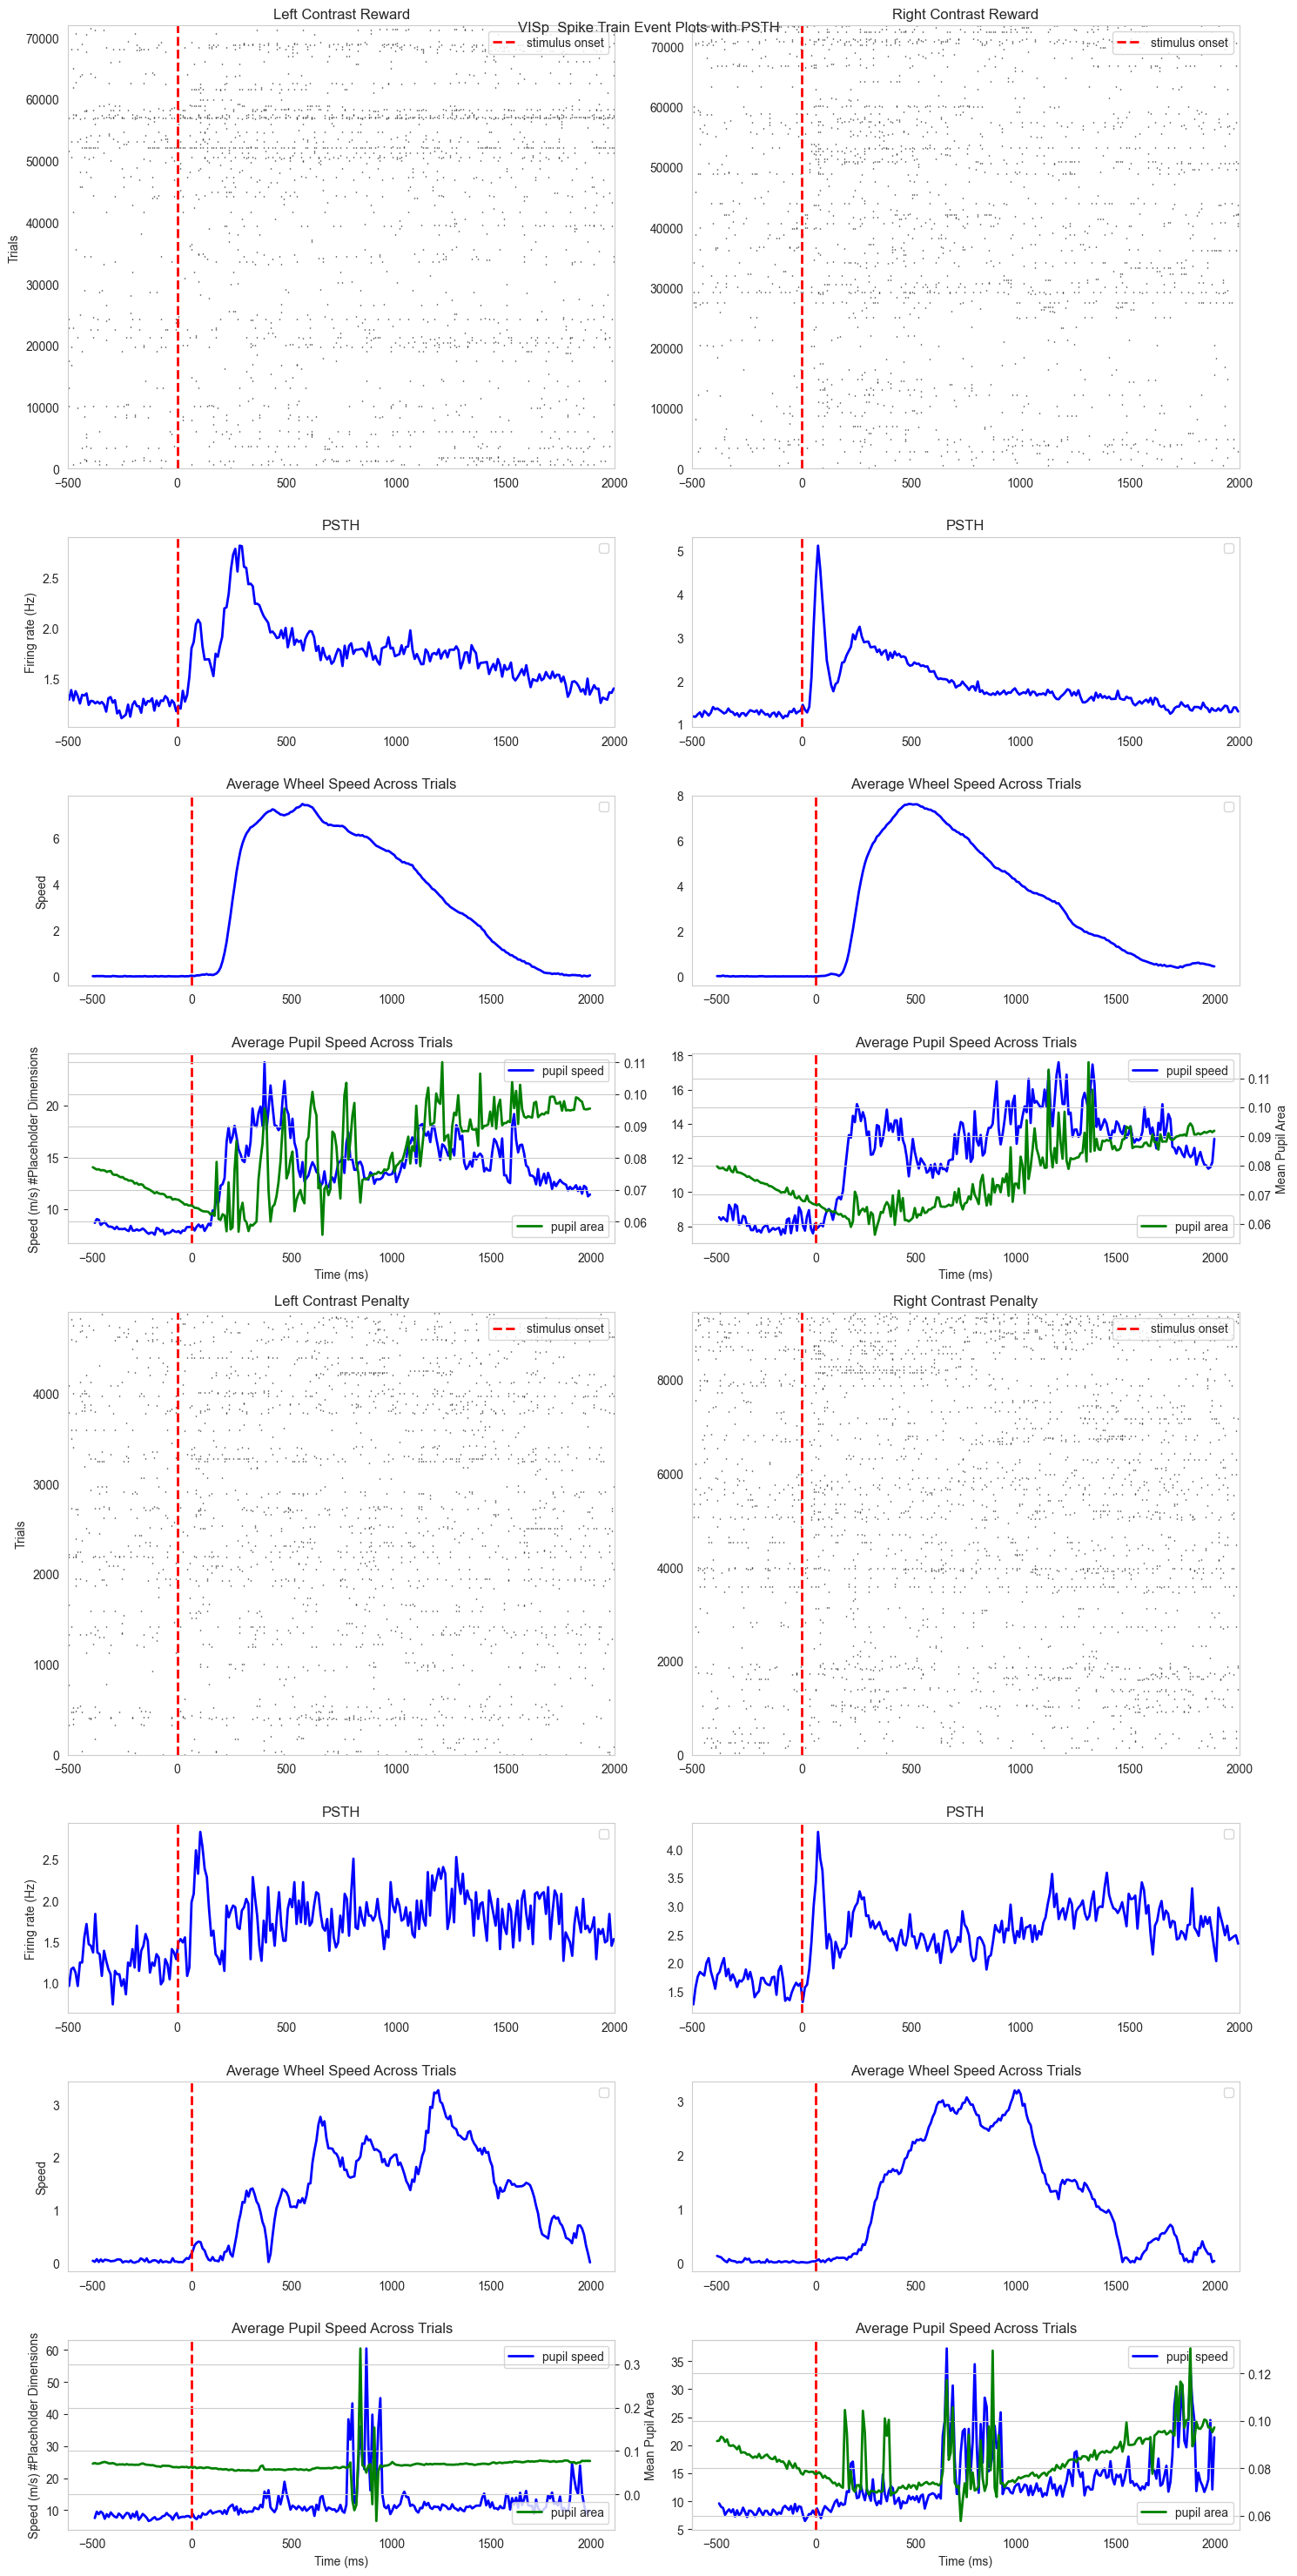

In [110]:
# # Assuming you have a DataFrame 'df' with required columns
fig = plot_decision_trials_eventplot(data_df=concat_df, area='VISp')
plt.show()